# Lab | Cross Validation

For this lab, we will build a model on customer churn binary classification problem. You will be using `files_for_lab/Customer-Churn.csv` file.

In [49]:
import pandas as pd
import numpy as np
import warnings
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, Normalizer, LabelEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [36]:
df = pd.read_csv('/Users/spicasumampouw/IronSpica/lab/Unit_7/lab-cross-validation/files_for_lab/Customer-Churn.csv')
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,Yes,No,No,No,No,Month-to-month,29.85,29.85,No
1,Male,0,No,No,34,Yes,Yes,No,Yes,No,No,No,One year,56.95,1889.5,No
2,Male,0,No,No,2,Yes,Yes,Yes,No,No,No,No,Month-to-month,53.85,108.15,Yes
3,Male,0,No,No,45,No,Yes,No,Yes,Yes,No,No,One year,42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,No,No,No,No,No,Month-to-month,70.70,151.65,Yes


In [37]:
df.shape

(7043, 16)

In [39]:
df.columns = [column.lower().replace(' ', '_') for column in df.columns]
df.columns

Index(['gender', 'seniorcitizen', 'partner', 'dependents', 'tenure',
       'phoneservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies', 'contract',
       'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')

In [40]:
df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce')

In [41]:
unk_lst = []
for col in df.columns:
    column_name = col
    unk_values = int(df[col].isnull().sum())
    unk_dtypes = df[col].dtypes
    unk_lst.append([column_name,unk_values,unk_dtypes])
    
unk_df = pd.DataFrame(unk_lst,columns=["Column Name","Unknown Values", "Data Types"])
unk_df.sort_values("Unknown Values", ascending=False).iloc[:16]

,Column Name,Unknown Values,Data Types
14,totalcharges,11,float64
0,gender,0,object
1,seniorcitizen,0,int64
2,partner,0,object
3,dependents,0,object
4,tenure,0,int64
5,phoneservice,0,object
6,onlinesecurity,0,object
7,onlinebackup,0,object
8,deviceprotection,0,object


In [42]:
def replace_by_mean(data, columns = []):
    for i in columns:
        data[i].fillna(data[i].mean(), inplace = True)

In [43]:
replace_by_mean(df, columns = ["totalcharges"])

In [44]:
pd.DataFrame(df.isna().sum()*100/len(df), columns=['percentage'])

,percentage
gender,0.0
seniorcitizen,0.0
partner,0.0
dependents,0.0
tenure,0.0
phoneservice,0.0
onlinesecurity,0.0
onlinebackup,0.0
deviceprotection,0.0
techsupport,0.0


1. Apply SMOTE for upsampling the data
    - Use logistic regression to fit the model and compute the accuracy of the model.
    - Use decision tree classifier to fit the model and compute the accuracy of the model.
    - Compare the accuracies of the two models.

In [45]:
X = df[['seniorcitizen', 'tenure', 'monthlycharges', 'totalcharges']]
y = df['churn']

In [85]:
transformer = Normalizer() 
transformer.fit(X)
x_normalized = transformer.transform(X)
x_normalized.shape

(7043, 4)

In [86]:
smote = SMOTE()
X_sm, y_sm = smote.fit_resample(X, y)
y_sm.value_counts()

No     5174
Yes    5174
Name: churn, dtype: int64

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=100)
model = LogisticRegression()
model.fit(X_train,y_train)
preds = model.predict(X_test)
print(classification_report(y_test, preds))
score_sm_class = round(model.score(X_test, y_test),2)
print("smote accuracy score & logistic regression:", score_sm_class)

              precision    recall  f1-score   support

          No       0.76      0.69      0.72      1052
         Yes       0.71      0.78      0.74      1018

    accuracy                           0.73      2070
   macro avg       0.73      0.73      0.73      2070
weighted avg       0.73      0.73      0.73      2070

smote accuracy score & logistic regression: 0.73


In [88]:
X_sm, y_sm = load_iris(return_X_y=True)
print(X.shape)
print(y.shape)

(7043, 4)
(7043,)


In [89]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=100)
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(classification_report(y_test, preds))
score_sm_dec = round(model.score(X_test, y_test),2)
print("smote accuracy score & decision tree:", score_sm_dec)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      0.83      0.91         6
           2       0.93      1.00      0.96        13

    accuracy                           0.97        30
   macro avg       0.98      0.94      0.96        30
weighted avg       0.97      0.97      0.97        30

smote accuracy score & decision tree: 0.97


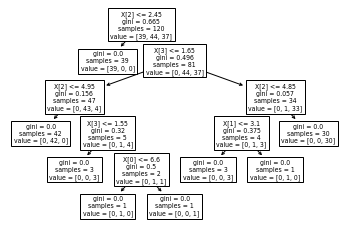

In [90]:
tree.plot_tree(model);

In [91]:
print("smote accuracy score & logistic regression:", score_sm_class)
print("smote accuracy score & decision tree:", score_sm_dec)

smote accuracy score & logistic regression: 0.73
smote accuracy score & decision tree: 0.97


2. Apply TomekLinks for downsampling
    - It is important to remember that it does not make the two classes equal but only removes the points from the majority class that are close to other points in minority class.
    - Use logistic regression to fit the model and compute the accuracy of the model.
    - Use decision tree classifier to fit the model and compute the accuracy of the model.
    - Compare the accuracies of the two models.
    - You can also apply this algorithm one more time and check the how the imbalance in the two classes changed from the last time.

In [92]:
tomek = TomekLinks()
X_tl, y_tl = tomek.fit_resample(X, y)
y_tl.value_counts()

No     4620
Yes    1869
Name: churn, dtype: int64

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X_tl, y_tl, test_size=0.2, random_state=100)
model = LogisticRegression()
model.fit(X_train,y_train)
preds = model.predict(X_test)
print(classification_report(y_test, preds))
score_tom_class = round(model.score(X_test, y_test),2)
print("tomeklinks accuracy score & logistic regression:", score_tom_class)

              precision    recall  f1-score   support

          No       0.83      0.90      0.86       891
         Yes       0.73      0.59      0.65       407

    accuracy                           0.80      1298
   macro avg       0.78      0.74      0.76      1298
weighted avg       0.80      0.80      0.80      1298

tomeklinks accuracy score & logistic regression: 0.8


In [94]:
X_tl, y_tl = load_iris(return_X_y=True)
print(X.shape)
print(y.shape)

(7043, 4)
(7043,)


In [95]:
X_train, X_test, y_train, y_test = train_test_split(X_tl, y_tl, test_size=0.2, random_state=100)
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(classification_report(y_test, preds))
score_tom_dec = round(model.score(X_test, y_test),2)
print("tomeklinks accuracy score & decision tree:", score_tom_dec)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      0.83      0.91         6
           2       0.93      1.00      0.96        13

    accuracy                           0.97        30
   macro avg       0.98      0.94      0.96        30
weighted avg       0.97      0.97      0.97        30

tomeklinks accuracy score & decision tree: 0.97


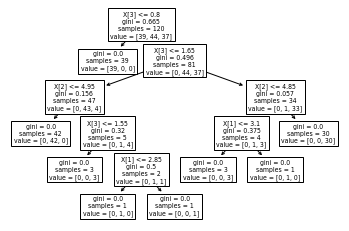

In [96]:
tree.plot_tree(model);

In [97]:
print("tomeklinks accuracy score & logistic regression:", score_tom_class)
print("tomeklinks accuracy score & decision tree:", score_tom_dec)

tomeklinks accuracy score & logistic regression: 0.8
tomeklinks accuracy score & decision tree: 0.97
